In [49]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
#export
from exp.nb_05 import *

## Early stopping
### Better callback cancellation by using exceptions as a control-flow technique
Until now we used `return False` (or `return True` with the `Runner` class) in the Callbacks to cancel training. We want more flexibility deciding whether we want to cancel a batch, an epoch, or training altoghether. To do this we define the exceptions `CancelTrainException`, `CancelEpochException`, `CancelBatchException`.

In [51]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [52]:
nh, bs = 50, 512
c = y_train.max().item() + 1

In [53]:
loss_func = F.cross_entropy

In [54]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [55]:
#export
class Callback():
    _order = 0  # We need a mechanism to define an order in which callbacks run
    def set_runner(self, run):
        self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False 
    
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train: return  # count of iters does not have to be increased
        self.run.n_epochs += 1./self.iters  # delegate to the runner which has iters attribute (all_batches func)
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch  # delegated to the runner which has a epoch attribute
        self.model.train()              # self.model also delegates to runner which retuns learn.model
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False  

In [56]:
#export
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [57]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)                              # Why don't we call setattr for the cb in cbs as well?
        for cbf in listify(cb_funcs):
            cb = cbf()  # function constructs the callback object
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()] + cbs
        
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb  # current batch
            self('begin_batch')  # calls __call__ of self with argument 'begin_batch':
                                 # __call__ calls all callbacks with argument 'begin_batch'
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
        
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb, yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
        
    def fit(self, epochs, learn):
        self.epochs, self.learn, self.loss = epochs, learn, tensor(0.)
        
        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)  
                # remember: if a cb returns True it means stop training
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None
            
    def __call__(self, cb_name):  # handles the calls self('cb name')
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [58]:
learn = create_learner(get_model, loss_func, data)

In [59]:
class TestCallback(Callback):
    _order = 1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [60]:
run = Runner(cb_funcs=TestCallback)

In [61]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


### Let's adapt the other callbacks

In [62]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        
    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(pg['lr'])
            
        self.losses.append(self.loss.detach().cpu())      # self.loss belongs to runner
    
    def plot_lr(self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses) - skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
    
    def set_param(self):
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)  
            # self.n_epochs=1.5 means we arrived at half of second epoch, self.epochs = total num of epochs
            
    def begin_batch(self):
        if self.in_train: self.set_param()

## Learning rate finder
**Note: You should add something that saves the model before running the lr finder and loads it back after running - otherwise you lose your weights!**

In [63]:
#export
class  LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [64]:
learn = create_learner(get_model, loss_func, data)

In [65]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [66]:
run.fit(3, learn)

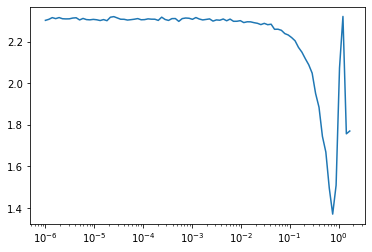

In [67]:
run.recorder.plot(skip_last=5)

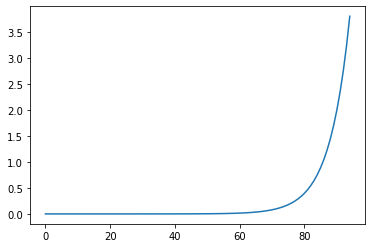

In [68]:
run.recorder.plot_lr()

### Export

In [69]:
!python notebook2script.py 05b_early_stopping.ipynb

Converted 05b_early_stopping.ipynb to exp/nb_05b.py
